In [238]:
import pandas as pd
import numpy as np
import random
import math
import argparse
import time
import torch.nn.functional as F
import copy
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import sklearn.metrics as metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import PolynomialFeatures,StandardScaler,MinMaxScaler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC,LinearSVC
from mpl_toolkits.mplot3d import Axes3D

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [239]:
class LinearNetwork(nn.Module):
    def __init__(self, in_dim = 3, n_hidden = 10, n_layer = 3, out_dim = 3, drop_rate=0.1):
        super(LinearNetwork, self).__init__()
        self.layer1 = nn.Linear(in_dim, n_hidden)
        self.layer2 = nn.Linear(n_hidden, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_hidden)
        self.layer4 = nn.Linear(n_hidden, n_hidden)
        self.layer5 = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden, out_dim)
        self.drop_rate = drop_rate
        self.n_layer = n_layer
        self.x_1=0
        self.x_2=0
        self.x_3=0


    def forward1(self, x):
        x = F.dropout(F.relu(self.layer1(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        return y_pred

    def forward3(self, x):
        x_1 = F.relu(self.layer1(x))
        x_2 = F.relu(self.layer2(x_1))
        x_3 = F.dropout(F.relu(self.layer3(x_2)), p=self.drop_rate)
        y_pred = self.out(x_3)
        # y_pred.backward()
        return x_1,x_2,x_3,y_pred

    def forward5(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.dropout(F.relu(self.layer5(x)), p=self.drop_rate)
        y_pred = torch.sigmoid(self.out(x))
        # print('layer1', self.layer1.weight.grad.size())
        # print('layer2', self.layer2.weight.grad.size())
        # print('layer3', self.layer3.weight.grad.size())
        # print('out', self.out.weight.grad.size())
        return y_pred

    def forward(self, x):
        if self.n_layer == 1:
            return self.forward1(x)
        elif self.n_layer == 3:
            return self.forward3(x)
        elif self.n_layer == 5:
            return self.forward5(x)
        else:
            raise AssertionError

In [240]:
random_data = datasets.make_classification(n_samples=5000, class_sep = 1, random_state = 1,
                                           n_features=3, n_informative = 3, n_redundant = 0, n_classes=3)
random_data_x, random_data_y = random_data[0], random_data[1]

# # 数据集可视化
# visable_num = 450
# fig2 = plt.figure(1, figsize=(8, 6))
# ax2 = Axes3D(fig2, elev=-150, azim=110)
# ax2.scatter(random_data_x[:visable_num][:, 0], random_data_x[:visable_num][:, 1], 
#             random_data_x[:visable_num][:, 2], c=random_data_y[:visable_num],
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax2.set_title("random_data")
# ax2.set_xlabel("dim 1")
# ax2.w_xaxis.set_ticklabels([])
# ax2.set_ylabel("dim 2")
# ax2.w_yaxis.set_ticklabels([])
# ax2.set_zlabel("dim 3")
# ax2.w_zaxis.set_ticklabels([])

In [241]:
def randomData_loader(x, y, batch_size = 5000):
    random_data_num = len(y)
    X_train = torch.tensor(x[:int(random_data_num*0.9)], dtype=torch.float,requires_grad=True )
    X_val = torch.tensor(x[int(random_data_num*0.9):-int(random_data_num*0.05)], dtype=torch.float,requires_grad=True)
    X_test = torch.tensor(x[-int(random_data_num*0.05):], dtype=torch.float,requires_grad=True)
    print(X_train.requires_grad)

    y = torch.LongTensor(y)
    y_train = y[:int(random_data_num*0.9)]
    print('y_train.size()',y_train.size())
    y_val = y[int(random_data_num*0.9):-int(random_data_num*0.05)]
    # print(y_val)

    y_test = y[-int(random_data_num*0.05):]
    
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    test_data = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
    loader = {'train':train_loader, 'val':val_loader, 'test':test_loader}
    return loader

np.random.seed(123)
loader_random = randomData_loader(random_data_x, random_data_y)

True
y_train.size() torch.Size([4500])


In [242]:
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, random_state=1234)# 17 17 16

In [243]:
model_random_3_10 = LinearNetwork().to(device)

In [ ]:
def yL_Wl(L,layer):
# layer1 l/l-1/L
L_dim = list_dim[L]
l_plus_dim = list_dim[layer+1]
l_dim = list_dim[layer]
l_minus_dim = list_dim[layer-1]

k = np.zeros((l_dim,l_minus_dim,L_dim))
dim_3 = np.zeros((l_plus_dim,L_dim))

for i in range(l_dim):# L-2(l)
    temp_y = list_y[layer-1]
    if list_W[layer][i].dot(temp_y.T) < 0 or list_W[layer][i].dot(temp_y.T) = 0:
        temp_y.fill(0)


    for _ in range(L,layer+1):
        if _ == L:
            dim_3[i] = list_W[L]
        else:
            dim_3[i] = dim_3[i].dot(list_W[_])
    dim_3[i] = dim_3[i].dot(list_W[layer+1][:,i])

    for j in range(l_minus_dim):
        k[i,j] = dim_3[i].dot(temp_y[j])

return k

In [279]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=2, is_inception=False):
    list_F = []
    list_y = []
    list_sigma = []
    list_beta = []
    list_W = []
    list_yL_Wl = []
    since = time.time()

#     val_acc_history = []
    acc_history = {'train':[], 'val':[], 'test':[]}
    loss_history = {'train':[], 'val':[], 'test':[]}
    f1_history = {'train':[], 'val':[], 'test':[]}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val', 'test']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                # train_labels_zero = 
                labels = labels.to(device)


                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # 不会执行
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        #L-1
                        x_1,x_2,last_L,outputs = model(inputs)
                        print('outputsize',outputs.size())
                        last_L_avg = last_L.mean(axis=0)
                        alpha = last_L_avg.sum(axis=0)
                        # print(last_L.size())
                        print('last_L_avg',last_L_avg)
                        print('alpha',alpha)
                        loss = criterion(outputs, labels)
                        # loss_zero = criterion(outputsize)


                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
    
                        outputs.retain_grad()
                        loss.backward(retain_graph=True)
                        W1_grad = model.layer1.weight.grad
                        W2_grad = model.layer2.weight.grad
                        W3_grad = model.layer3.weight.grad
                        out_grad = model.out.weight.grad
                        list_F.append("")      
                        list_F.append(W1_grad)
                        list_F.append(W2_grad)
                        list_F.append(W3_grad)
                        list_F.append(out_grad)

                        list_W.append("")      
                        list_W.append(model.layer1.weight)
                        list_W.append(model.layer2.weight)
                        list_W.append(model.layer3.weight)
                        list_W.append(model.out.weight)


                        for i in range(1,L):
                            list_yL_Wl.append(yL_Wl(L,i))

                        # layer out

                        k = np.zeros((list_dim[L],list_dim[L-1],list_dim[L]))
                        temp_y = list_y[L-1].numpy()
                        for i in range(list_dim[L]):
                            k[i,:,i] = temp_y
                        list_yL_Wl.append(k)
                        # k = np.zeros((3,10,3))
                        # temp_y = x_3.numpy()
                        # for i in range(3):
                        #     k[i,:,i] = temp_y
                        

                        # yL_Wl(4,3)
                        # # layer3 l/l-1/L
                        # k = np.zeros((10,10,3))
                        # dim_3 = np.zeros((10,3))


                        # for i in range(10):# L-2(l)
                        #     temp_y = x_2.numpy()
                        #     if model.layer3.weight[i].dot(inputs) < 0 or model.layer3.weight[i].dot(inputs) = 0:
                        #         temp_y.fill(0)
                        #     dim_3[i] = model.out.weight[:,i]
                        #     for j in range(10):
                        #         k[i,j] = dim_3[i].dot(temp_y[j])

                        # yL_Wl(4,2)

                        # layer2 l/l-1/L
                        # k = np.zeros((10,10,3))
                        # dim_3 = np.zeros((10,3))

                        # for i in range(10):# L-2(l)
                        #     temp_y = x_1.numpy()
                        #     if model.layer2.weight[i].dot(inputs) < 0 or model.layer2.weight[i].dot(inputs) = 0:
                        #         temp_y.fill(0)
                        #     dim_3[i] = model.out.weight.dot(model.layer3.weight[:,i])
                        #     for j in range(10):
                        #         k[i,j] = dim_3[i].dot(temp_y[j])



                        # yL_Wl(4,1)

                        # layer1 l/l-1/L
                        # k = np.zeros((10,10,3))
                        # dim_3 = np.zeros((10,3))

                        # for i in range(10):# L-2(l)
                        #     temp_y = inputs.numpy()
                        #     if model.layer1.weight[i].dot(inputs) < 0 or model.layer1.weight[i].dot(inputs) = 0:
                        #         temp_y.fill(0)
                        #     dim_3[i] = model.out.weight.dot(model.layer3.weight).dot(model.layer2.weight[:,i])
                        #     for j in range(10):
                        #         k[i,j] = dim_3[i].dot(temp_y[j])

            

                        
                        temp = model.outputs.grad[0]

    












                        # print(last_L.size())

                        # print('layer1', model.layer1.weight.grad.size())
                        W1_grad = model.layer1.weight.grad
                        W2_grad = model.layer2.weight.grad
                        W3_grad = model.layer3.weight.grad

                        # print('layer2', model.layer2.weight.grad.size())
                        # print('layer3', model.layer3.weight.grad)
                        # print('out', model.out.weight.grad.size())

                        # optimizer.zero_grad()
                        # optimizer.zero_grad()
                        # print(outputs[0])
                        # outputs[0].backward(torch.ones_like(outputs[0]),retain_graph=True)
                        # print('layer1', model.layer1.weight.grad.size())
                        # print('layer2', model.layer2.weight.grad.size())
                        # print('layer3', model.layer3.weight.grad)
                        # print('out', model.out.weight.grad)
                        # print(last_L)


                        # print('y', outputs.size())
                        # print('y_W',model.layer3.weight.grad)
                        # y_grad_matrix = outputs.grad
                        # y_grad = y_grad_matrix.mean(axis=0)
                        # d(y^L/W^l)
                        # YLWl = grad
                        






                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            preds = np.array(preds.cpu())
            ytest = np.array(labels.data.cpu())
            epoch_f1 = metrics.f1_score(ytest, preds, zero_division=False, average='macro')
            acc_history[phase].append(np.array(epoch_acc.cpu()))
            loss_history[phase].append(epoch_loss)
            f1_history[phase].append(epoch_f1)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, acc_history, loss_history, f1_history

In [280]:
# random
num_epochs_random = 1
criterion = nn.CrossEntropyLoss()

params_to_update310 = model_random_3_10.parameters()


optimizer_ft310 = optim.Adam(params_to_update310, lr=0.001)


model_ft310r, hist310r, loss310r, f1_310r = train_model(model_random_3_10, loader_random, criterion, optimizer_ft310, num_epochs=num_epochs_random)


Epoch 0/0
----------
outputsize torch.Size([4500, 3])
last_L_avg tensor([0.0250, 0.0000, 0.2284, 0.0894, 0.3316, 0.1093, 0.0000, 0.0000, 0.0005,
        0.1230], grad_fn=<MeanBackward1>)
alpha tensor(0.9072, grad_fn=<SumBackward1>)
tensor([-0.2519,  0.3311, -0.2805], grad_fn=<SelectBackward>)
layer1 torch.Size([10, 3])
layer2 torch.Size([10, 10])
layer3 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1011, 0.0000, 0.0000, 0.0000, 0.1471, 0.0566, 0.0000,
         0.1150],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

In [281]:
# def test_model(model, loader):
#     model.eval()
#     all_outputs = []
#     with torch.no_grad():
#         for inputs, labels in loader['test']:
#             inputs = inputs.to(device)
#             test_outputs = model(inputs)
#             _, preds = torch.max(test_outputs, 1)
#             all_outputs = np.concatenate((all_outputs, preds.cpu().numpy()))
            
#     return np.mean(all_outputs== np.array(labels))

# test_model(model_ft, loader)

In [282]:
def draw3(hist310,f1_310, num_epochs):
    # 使用tex渲染
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    x = range(num_epochs)

    plt.figure(figsize=(25, 15))

    plt.subplot(321)
    plt.plot(x, hist310['train'], 'r', label = 'train')
    plt.plot(x, hist310['val'], 'g', label = 'val')
    plt.plot(x, hist310['test'], 'b', label = 'test')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('Accuracy', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)
    
    plt.subplot(322)
    plt.plot(x, f1_310['train'], 'r', label = 'train')
    plt.plot(x, f1_310['val'], 'g', label = 'val')
    plt.plot(x, f1_310['test'], 'b', label = 'test')
    # plt.xlabel('epoch', fontsize=30)
    plt.ylabel('macro F1-score', fontsize=30)
    plt.tick_params(labelsize=30)
    plt.legend(fontsize=30)


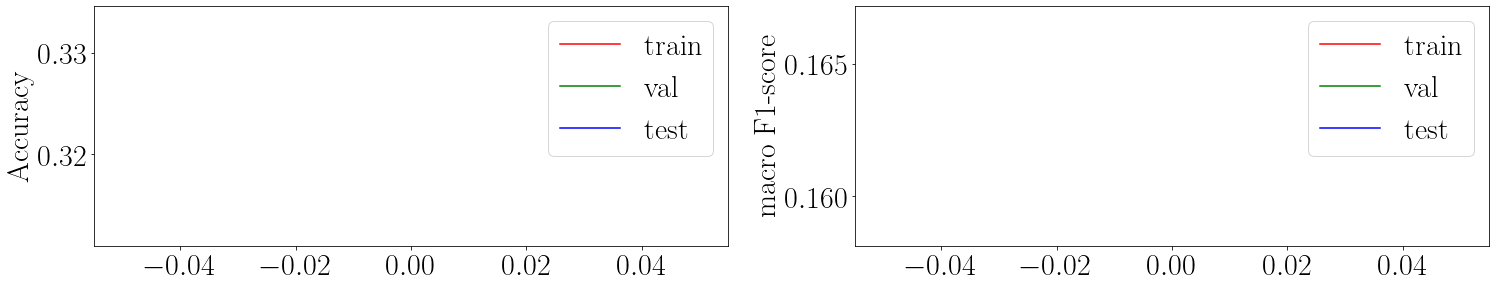

In [283]:
draw3(hist310r,f1_310r,  num_epochs_random)

In [284]:

random_list = [hist310r,  f1_310r]

def all_f1(data_list):
#     data_list.cpu()
    max_list = []
    for j,i in enumerate(data_list[1:]):
        f1_max = np.mean(i['test'][-10:])
#         print(np.array(data_list[j]['test'])[-5:])
        acc_max = np.mean(np.array(data_list[j]['test'])[-10:])
        max_list.append([f1_max, acc_max])
#         f1_max = np.max(i['test'])
#         loc = np.where(i['test'] == f1_max)
#         acc_max = np.max(np.array(data_list[j]['test'])[loc])
#         max_list.append([f1_max, acc_max])
    return np.array(max_list)


random_best = all_f1(random_list)

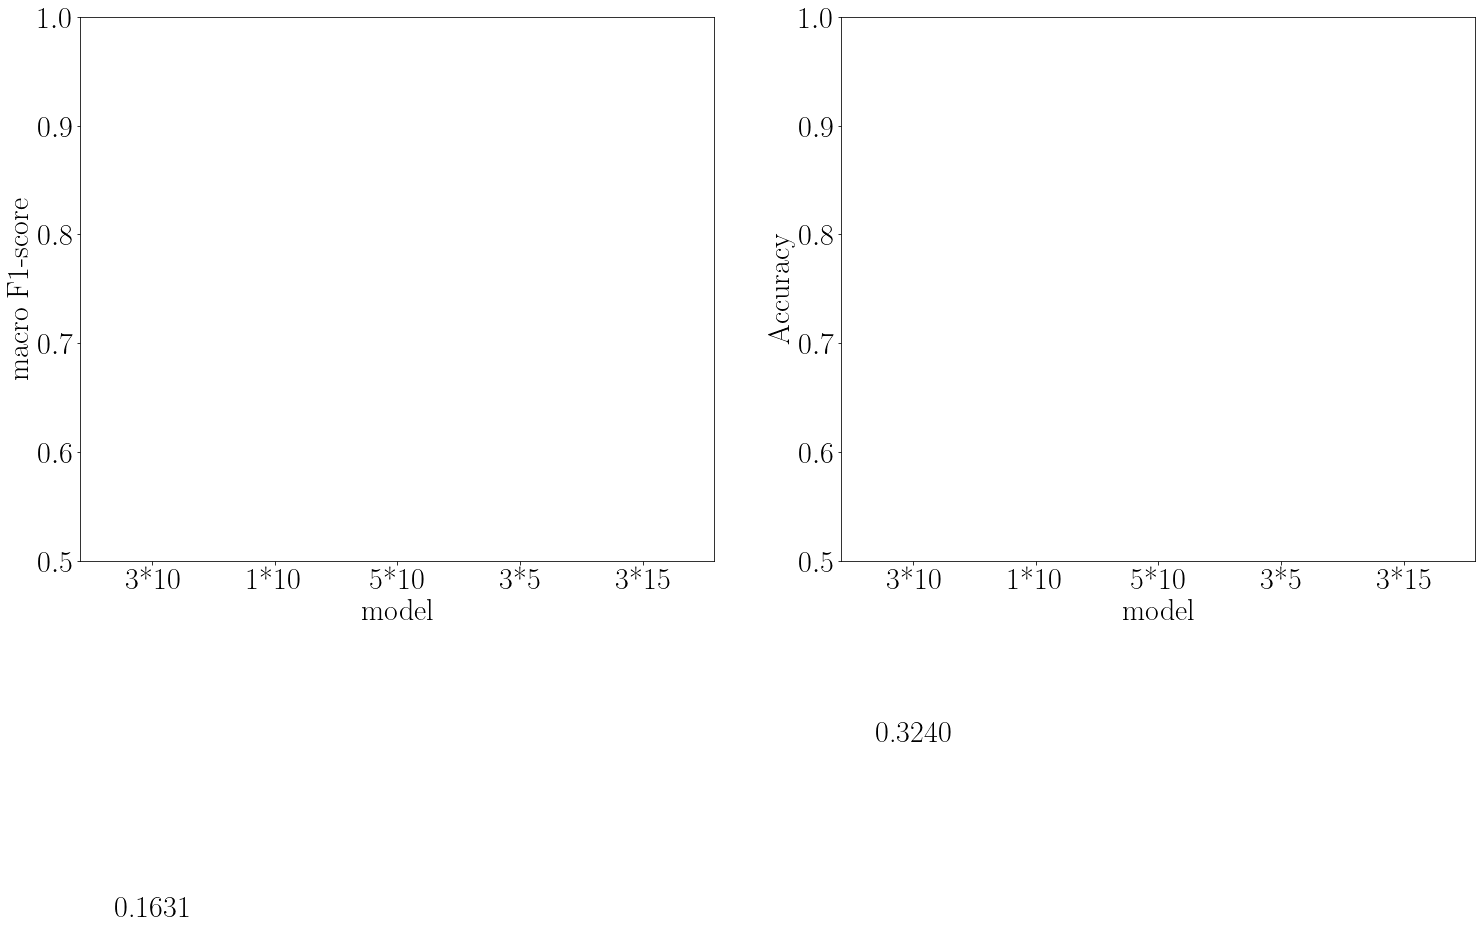

In [285]:
def draw_bar(data_list, num_epochs = 5):
    # 使用tex渲染
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    x = range(num_epochs)

    plt.figure(figsize=(25, 10))

    plt.subplot(121)
    plt.bar(range(5), data_list[:,0], width=0.7, color='dodgerblue', alpha=0.8)      # 从下往上画
    plt.xticks(range(5), ['3*10', '1*10', '5*10', '3*5', '3*15'])
    plt.ylim(0.5,1)
    plt.xlabel("model", fontsize=30)
    plt.ylabel("macro F1-score", fontsize=30)
    plt.tick_params(labelsize=30)
    for x, y in enumerate(data_list[:,0]):
        plt.text(x -0.3, y + 0.01, '%.4f' % y, fontsize=30)

    
    plt.subplot(122)
    plt.bar(range(5), data_list[:,1], width=0.7, color='limegreen', alpha=0.8)      # 从下往上画
    plt.xticks(range(5), ['3*10', '1*10', '5*10', '3*5', '3*15'])
    plt.ylim(0.5,1)
    plt.xlabel("model", fontsize=30)
    plt.ylabel("Accuracy", fontsize=30)
    plt.tick_params(labelsize=30)
    for x, y in enumerate(data_list[:,1]):
        plt.text(x -0.3, y + 0.01, '%.4f' % y, fontsize=30)


draw_bar(random_best)